## Regularization and Dropout 正则化

实现了对权重的正则化，引入`Dropout`。

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

- 载入数据集

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


- 处理一下数据集作为输入

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

- `Logistic Regression` 逻辑回归
- `Regulation` 正则化
- `Accurancy` 88%

In [23]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  lambda_regu = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + lambda_regu * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [18]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lambda_regu: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 21.915903
Minibatch accuracy: 9.4%
Validation accuracy: 8.8%
Minibatch loss at step 500: 2.518258
Minibatch accuracy: 80.5%
Validation accuracy: 76.9%
Minibatch loss at step 1000: 1.546754
Minibatch accuracy: 80.5%
Validation accuracy: 78.9%
Minibatch loss at step 1500: 1.432281
Minibatch accuracy: 77.3%
Validation accuracy: 80.9%
Minibatch loss at step 2000: 0.832008
Minibatch accuracy: 82.8%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 0.757161
Minibatch accuracy: 82.0%
Validation accuracy: 81.8%
Minibatch loss at step 3000: 0.770034
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Test accuracy: 88.6%


- 因为正则化参数不知道该如何选择，所以进行测试，发现`1e-3`比较好

In [ ]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lambda_regu : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

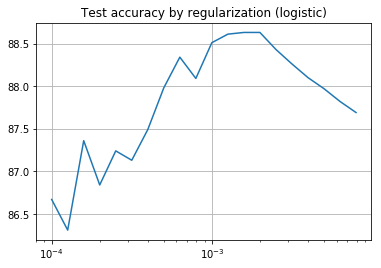

In [28]:
from matplotlib import pyplot as plt
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

- 三层网络
- 正则化
- `Accurancy` 93%

In [31]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  lambda_regu = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights_2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  logits = tf.matmul(hidden, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    lambda_regu * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)

In [32]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lambda_regu: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 695.143860
Minibatch accuracy: 11.7%
Validation accuracy: 34.3%
Minibatch loss at step 500: 191.012466
Minibatch accuracy: 85.9%
Validation accuracy: 81.7%
Minibatch loss at step 1000: 113.954475
Minibatch accuracy: 82.8%
Validation accuracy: 79.9%
Minibatch loss at step 1500: 69.089806
Minibatch accuracy: 79.7%
Validation accuracy: 83.7%
Minibatch loss at step 2000: 41.309517
Minibatch accuracy: 90.6%
Validation accuracy: 84.8%
Minibatch loss at step 2500: 25.169491
Minibatch accuracy: 88.3%
Validation accuracy: 86.5%
Minibatch loss at step 3000: 15.394077
Minibatch accuracy: 88.3%
Validation accuracy: 87.5%
Test accuracy: 93.0%


- 因为正则化参数不知道该如何选择，所以进行测试，发现`1e-3`比较好

In [33]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lambda_regu : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

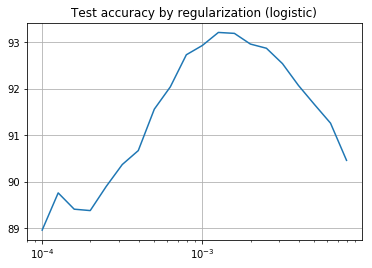

In [35]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

- 将训练数据限制在一个小范围内，发现训练集准确率很高，测试集和验证集就很差

In [36]:
num_steps = 3001
a_few_batches = 5

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (a_few_batches * batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lambda_regu: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 637.683899
Minibatch accuracy: 6.2%
Validation accuracy: 32.9%
Minibatch loss at step 500: 190.933517
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Minibatch loss at step 1000: 115.792572
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Minibatch loss at step 1500: 70.222961
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Minibatch loss at step 2000: 42.587135
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Minibatch loss at step 2500: 25.827457
Minibatch accuracy: 100.0%
Validation accuracy: 76.1%
Minibatch loss at step 3000: 15.664238
Minibatch accuracy: 100.0%
Validation accuracy: 76.6%
Test accuracy: 82.8%


- 三层网络
- `Dropout`
- `Accurancy` 92%

In [38]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  keep_prob = tf.placeholder(tf.float32)
  lambda_regu = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights_2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  hidden_drop = tf.nn.dropout(hidden, keep_prob)
  logits = tf.matmul(hidden_drop, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    lambda_regu * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_hidden_prob = tf.nn.dropout(valid_hidden, 1)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_prob, weights_2) + biases_2)
  # it is also ok
  #valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden, weights_2) + biases_2)
    
  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_hidden_drop = tf.nn.dropout(test_hidden, 1)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_drop, weights_2) + biases_2)

In [40]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lambda_regu: 1e-3, keep_prob: 0.75}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 789.955505
Minibatch accuracy: 4.7%
Validation accuracy: 35.8%
Minibatch loss at step 500: 189.951035
Minibatch accuracy: 83.6%
Validation accuracy: 81.4%
Minibatch loss at step 1000: 114.906570
Minibatch accuracy: 78.9%
Validation accuracy: 78.7%
Minibatch loss at step 1500: 68.822655
Minibatch accuracy: 78.1%
Validation accuracy: 82.8%
Minibatch loss at step 2000: 41.219700
Minibatch accuracy: 85.2%
Validation accuracy: 84.9%
Minibatch loss at step 2500: 25.150171
Minibatch accuracy: 86.7%
Validation accuracy: 85.8%
Minibatch loss at step 3000: 15.422319
Minibatch accuracy: 87.5%
Validation accuracy: 86.6%
Test accuracy: 92.7%


- 将训练数据限制在一个小范围内，发现训练集准确率很高，测试集和验证集就很差
- 但是加了`Dropout`，就好多了

In [43]:
num_steps = 3001
a_few_batches = 5

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (a_few_batches * batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lambda_regu: 1e-3, keep_prob: 0.75}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 701.468994
Minibatch accuracy: 8.6%
Validation accuracy: 31.8%
Minibatch loss at step 500: 190.662994
Minibatch accuracy: 100.0%
Validation accuracy: 77.3%
Minibatch loss at step 1000: 115.648041
Minibatch accuracy: 100.0%
Validation accuracy: 77.8%
Minibatch loss at step 1500: 70.145401
Minibatch accuracy: 100.0%
Validation accuracy: 78.1%
Minibatch loss at step 2000: 42.542118
Minibatch accuracy: 100.0%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 25.800838
Minibatch accuracy: 100.0%
Validation accuracy: 78.0%
Minibatch loss at step 3000: 15.647261
Minibatch accuracy: 100.0%
Validation accuracy: 78.0%
Test accuracy: 85.0%


- 四层网络
- `Adagrad Optimizer`
- 正则化
- `Dropout`
- 参数初始化真的非常影响结果
- https://github.com/rndbrtrnd/udacity-deep-learning/blob/master/3_regularization.ipynb 达到了96%
- 官方说可以达到97&

In [65]:
batch_size = 128
num_hidden1_nodes = 1024
num_hidden2_nodes = 256

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  keep_prob = tf.placeholder(tf.float32)
  lambda_regu = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden1_nodes], stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases_1 = tf.Variable(tf.zeros([num_hidden1_nodes]))
  weights_2 = tf.Variable(
    tf.truncated_normal([num_hidden1_nodes, num_hidden2_nodes], stddev=np.sqrt(2.0 / num_hidden1_nodes)))
  biases_2 = tf.Variable(tf.zeros([num_hidden2_nodes]))  
  weights_3 = tf.Variable(
    tf.truncated_normal([num_hidden2_nodes, num_labels], stddev=np.sqrt(2.0 / num_hidden2_nodes)))
  biases_3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  hidden1_drop = tf.nn.dropout(hidden1, keep_prob)
  hidden2 = tf.nn.relu(tf.matmul(hidden1_drop, weights_2) + biases_2)
  hidden2_drop = tf.nn.dropout(hidden2, keep_prob)
  logits = tf.matmul(hidden2_drop, weights_3) + biases_3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    lambda_regu * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3))
  
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(0.3).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  valid_hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_hidden2 = tf.nn.relu(tf.matmul(valid_hidden1, weights_2) + biases_2)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden2, weights_3) + biases_3)
    
  test_hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_hidden2 = tf.nn.relu(tf.matmul(test_hidden1, weights_2) + biases_2)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden2, weights_3) + biases_3)

In [66]:
num_steps = 18001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lambda_regu: 1e-3, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.573497
Minibatch accuracy: 8.6%
Validation accuracy: 38.0%
Minibatch loss at step 500: 1.000830
Minibatch accuracy: 85.2%
Validation accuracy: 84.3%
Minibatch loss at step 1000: 0.822930
Minibatch accuracy: 84.4%
Validation accuracy: 85.5%
Minibatch loss at step 1500: 0.890118
Minibatch accuracy: 77.3%
Validation accuracy: 86.0%
Minibatch loss at step 2000: 0.625403
Minibatch accuracy: 89.8%
Validation accuracy: 85.2%
Minibatch loss at step 2500: 0.634579
Minibatch accuracy: 85.2%
Validation accuracy: 85.3%
Minibatch loss at step 3000: 0.696254
Minibatch accuracy: 84.4%
Validation accuracy: 85.9%
Minibatch loss at step 3500: 0.676903
Minibatch accuracy: 82.0%
Validation accuracy: 86.1%
Minibatch loss at step 4000: 0.736637
Minibatch accuracy: 82.0%
Validation accuracy: 86.2%
Minibatch loss at step 4500: 0.839940
Minibatch accuracy: 82.8%
Validation accuracy: 86.0%
Minibatch loss at step 5000: 0.660201
Minibatch accuracy: 85.2%
Validation accuracy